In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import torch

from code.distributions import *

In [2]:
SCORE_MEASURES = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'average_precision']
TIME_MEASURES = ['collecting_datasets', 'training', 'training_per_epoch', 'prediction']
MEASURES = SCORE_MEASURES + TIME_MEASURES

MEASURES_AGGREGATION = { m: ['mean', 'std'] for m in MEASURES }

MEASURE_NAMES = { m: m.capitalize().replace('_', ' ') for m in MEASURES }
for m in TIME_MEASURES:
    MEASURE_NAMES[m] += ' time [s]'

In [3]:
def aggregate_results(results, experiment_type):
    if not 'task' in results.columns:
        results['task'] = 1
    results_filtered = results[results['experiment_type'] == experiment_type]
    experiment_type = experiment_type.replace(' ', '_')
    return results_filtered.groupby([experiment_type, 'task']).agg(MEASURES_AGGREGATION)

In [4]:
# we decrease the number of plots in case of multilabel classification to make it more readable,

ICD9_TASKS = {
    1: (0.5807, 0.7643),
    2: (0.7422, 0.8467),
    3: (0.8377, 0.7203),
    4: (0.6556, 0.7575),
    5: (0.5058, 0.6680),
#     6: (0.4566, 0.6651),
#     7: (0.9592, 0.8435),
#     8: (0.7493, 0.7447),
#     9: (0.6393, 0.7023),
#     10: (0.7715, 0.8089),
#     11: (0.1498, 0.8200),
#     12: (0.1930, 0.6670),
#     13: (0.2641, 0.6185),
#     14: (0.1134, 0.7003),
#     15: (0.4848, 0.6583),
#     16: (0.1488, 0.6243),
#     17: (0.0742, 0.6976),
#     18: (0.6430, 0.6722),
#     19: (0.6684, 0.6931),
#     20: (0.5506, 0.6719),
}
ICD9_TASKS = {k: {"average_precision": v[0], "roc_auc": v[1]} for k, v in ICD9_TASKS.items()}

MORTALITY_TASKS = {1: {"average_precision": 0.4632, "roc_auc": 0.8496}}

In [5]:
def task_color(task):
    return plt.cm.tab20(task * 2 % 20)

def plot(grouped_results, xlabel, reference_results, is_x_categorical=False):
    if is_x_categorical:
        figsize_width_multiplier = 4.5
    else:
        figsize_width_multiplier = 3.5
        
    fig, axes = plt.subplots(nrows=len(MEASURES) // 2, ncols=2,
                             figsize=(15, figsize_width_multiplier * len(MEASURES)))
    
    for i, measure in enumerate(MEASURES):
        ax = axes[i // 2][i % 2]
        time_plot_done = False
        for task, task_data in reference_results.items():
            # only one plot for time data
            if measure in TIME_MEASURES and time_plot_done:
                continue
            df = grouped_results.xs(task, level=1)
            if measure in task_data:
                ax.axhline(task_data[measure], linestyle='--', c=task_color(task))
            ax.errorbar(
                df.index,
                df[measure]['mean'], df[measure]['std'],
                linestyle='None', marker='x', uplims=True, lolims=True,
                c=task_color(task),
            )
            if measure in TIME_MEASURES:
                time_plot_done = True
        xticks = grouped_results.index.get_level_values(0).unique().sort_values()
        if is_x_categorical:
            xticks = [tick.replace('_', ' ').capitalize() for tick in xticks]
            ax.set_xticklabels(xticks, rotation=30)
        else:
            ax.set_xscale('log')
            ax.set_xticks(xticks)
            ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        ax.set_xlabel(xlabel, size=14)
        ax.set_ylabel(MEASURE_NAMES[measure], size=14)
        ax.set_title(f'{xlabel} vs. {MEASURE_NAMES[measure]}', size=17)
        ax.grid(True)
    if is_x_categorical:
        plt.subplots_adjust(hspace=0.5)
    plt.show()

### Mortality

In [6]:
mortality_results = pd.read_csv('results/mortality_binary_classification.csv')

In [7]:
mortality_results

,experiment_type,train_size,num_of_workers,node_distribution,accuracy,precision,recall,f1_score,roc_auc,average_precision,collecting_datasets,training,training_per_epoch,prediction,task
0,train size,50.0,32,uniform,0.895062,0.000000,0.000000,0.000000,0.705478,0.299668,0.101133,29.557379,1.407494,7.756523,1
1,train size,50.0,32,uniform,0.895062,0.000000,0.000000,0.000000,0.587642,0.171583,0.099622,121.207708,1.393192,7.584324,1
2,train size,50.0,32,uniform,0.895062,0.000000,0.000000,0.000000,0.703474,0.279965,0.104363,29.556328,1.407444,7.514240,1
3,train size,50.0,32,uniform,0.895187,0.000000,0.000000,0.000000,0.720648,0.292622,0.100257,29.413432,1.400640,7.591133,1
4,train size,50.0,32,uniform,0.845074,0.222395,0.191432,0.205755,0.557738,0.178418,0.101794,351.141232,1.404565,7.601298,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,node distribution,NaN,32,uniform,0.905443,0.643411,0.221925,0.330020,0.842583,0.452603,0.106488,852.999519,21.871783,7.497240,1
91,node distribution,NaN,32,uniform,0.904181,0.610922,0.239305,0.343900,0.844279,0.454446,0.103402,919.166844,21.884925,7.494735,1
92,node distribution,NaN,32,uniform,0.904040,0.605960,0.244652,0.348571,0.860146,0.468637,0.102490,1080.460671,22.509597,7.176942,1
93,node distribution,NaN,32,uniform,0.908236,0.676806,0.238286,0.352475,0.850324,0.469581,0.101171,1147.842942,20.869872,7.173267,1


In [8]:
grouped_mortality_train_size = aggregate_results(mortality_results, 'train size')
grouped_mortality_train_size

accuracy           precision              recall            \
                     mean       std      mean       std      mean       std   
train_size task                                                               
50.0       1     0.885089  0.022369  0.044479  0.099458  0.038286  0.085611   
100.0      1     0.895109  0.000065  0.000000  0.000000  0.000000  0.000000   
500.0      1     0.892527  0.003407  0.376502  0.110652  0.062871  0.060079   
1000.0     1     0.895053  0.002345  0.505140  0.325256  0.072737  0.078335   
5000.0     1     0.901647  0.001003  0.600987  0.023667  0.188873  0.023937   
10000.0    1     0.903499  0.002068  0.638420  0.053194  0.193141  0.030314   

                 f1_score             roc_auc           average_precision  \
                     mean       std      mean       std              mean   
train_size task                                                             
50.0       1     0.041151  0.092017  0.654996  0.076165          0.244451   
100.0      1     0.000000  0.000000  0.672839  0.048322          0.233219   
500.0      1     0.102100  0.090709  0.682239  0.041059          0.225215   
1000.0     1     0.113326  0.112522  0.726461  0.007335          0.306251   
5000.0     1     0.286421  0.026420  0.804488  0.008908          0.404188   
10000.0    1     0.294499  0.032499  0.832372  0.007581          0.431931   

                          collecting_datasets              training  \
                      std                mean       std        mean   
train_size task                                                       
50.0       1     0.063837            0.101434  0.001835  112.175216   
100.0      1     0.035069            0.100967  0.000845   49.277545   
500.0      1     0.061088            0.100704  0.001072  108.016564   
1000.0     1     0.010546            0.101066  0.000489   55.892695   
5000.0     1     0.012046            0.101629  0.001475  187.212799   
10000.0    1     0.009953            0.103171  0.001365  429.758068   

                            training_per_epoch           prediction            
                        std               mean       std       mean       std  
train_size task                                                                
50.0       1     139.362336           1.402667  0.005992   7.609504  0.089063  
100.0      1      21.218456           1.644499  0.007830   7.535889  0.054442  
500.0      1      42.578921           1.882518  0.003448   7.419022  0.040455  
1000.0     1      14.233848           2.101707  0.007570   7.438099  0.041201  
5000.0     1      55.779880           4.925448  0.018997   7.543765  0.025387  
10000.0    1      52.402581           8.265012  0.037675   7.720399  0.139569

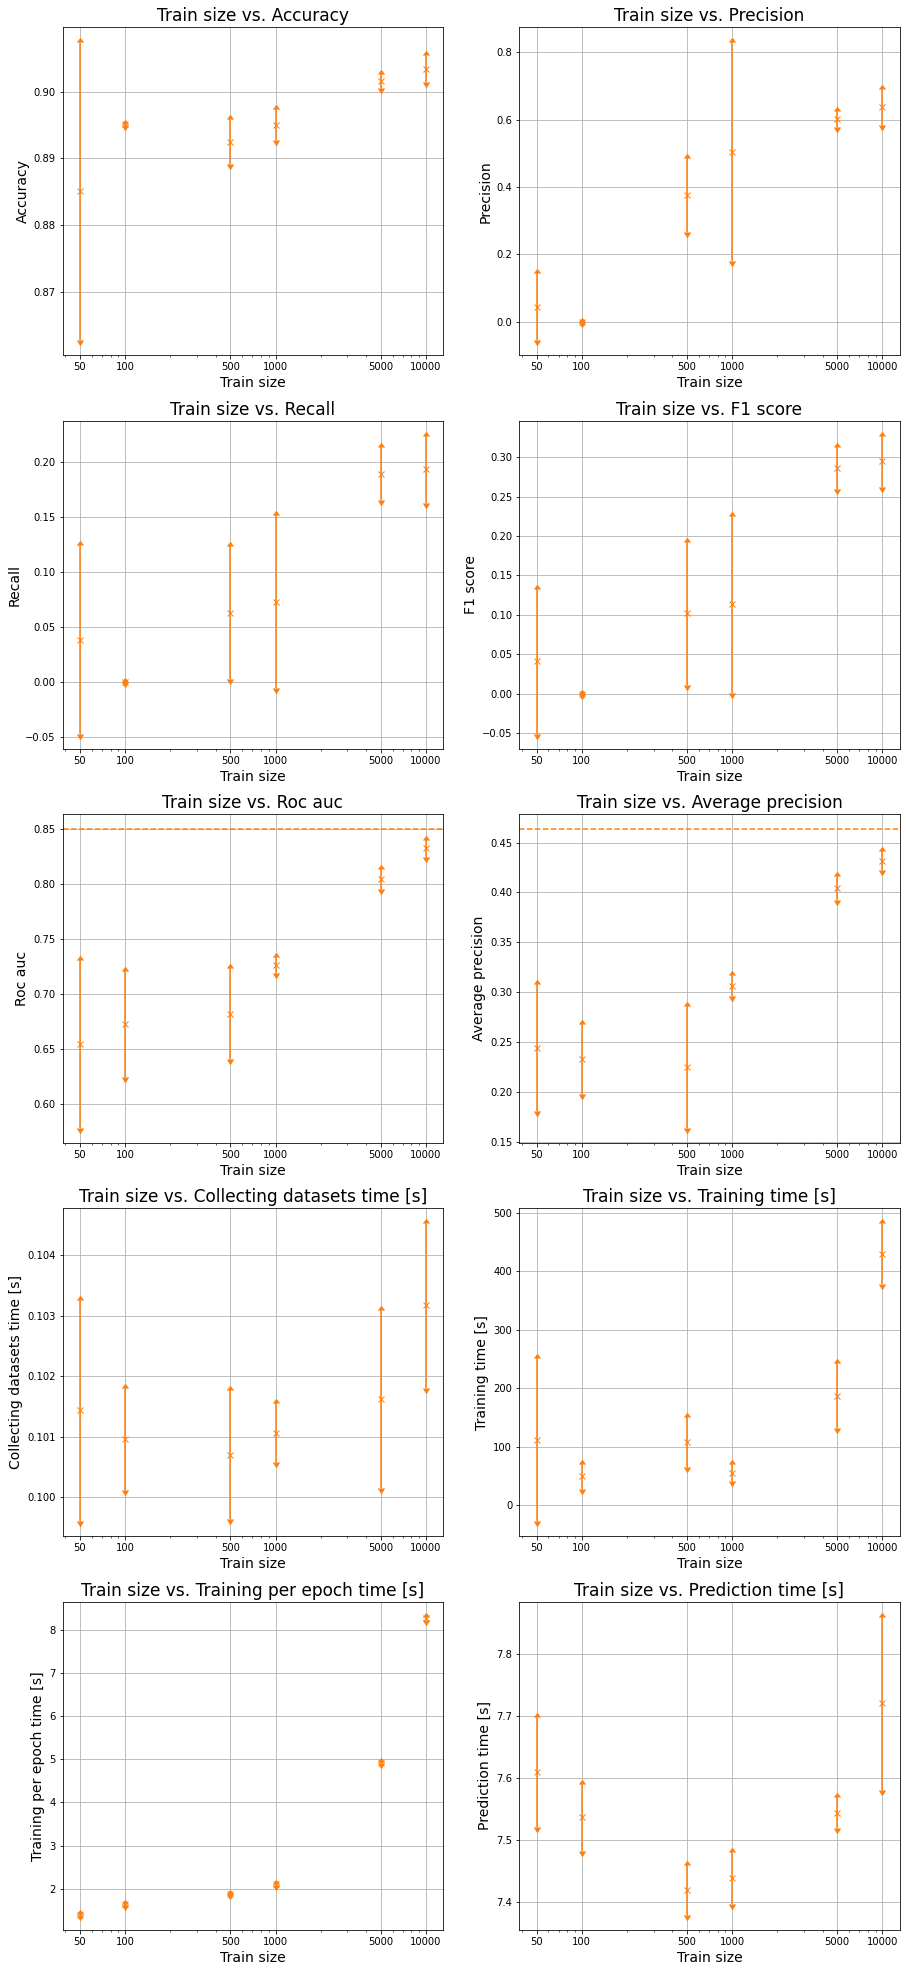

In [9]:
plot(grouped_mortality_train_size, 'Train size', MORTALITY_TASKS)

In [10]:
grouped_mortality_workers = aggregate_results(mortality_results, 'num of workers')
grouped_mortality_workers

accuracy           precision              recall  \
                         mean       std      mean       std      mean   
num_of_workers task                                                     
1              1     0.905548  0.002418  0.629737  0.038420  0.245586   
2              1     0.905660  0.001547  0.642212  0.041340  0.233272   
4              1     0.906249  0.001907  0.636328  0.033841  0.251469   
8              1     0.905435  0.001230  0.634632  0.022880  0.233814   
16             1     0.906109  0.002359  0.649266  0.041059  0.231941   
32             1     0.906165  0.001310  0.652469  0.023710  0.226589   
64             1     0.904902  0.001434  0.637225  0.030407  0.221509   
128            1     0.904790  0.002175  0.645500  0.044962  0.208930   

                               f1_score             roc_auc            \
                          std      mean       std      mean       std   
num_of_workers task                                                     
1              1     0.016580  0.352718  0.015526  0.853455  0.005337   
2              1     0.019870  0.341063  0.015704  0.853353  0.005024   
4              1     0.017767  0.359788  0.015418  0.852523  0.002822   
8              1     0.011581  0.341397  0.010117  0.852334  0.005068   
16             1     0.016540  0.341090  0.015825  0.852746  0.005926   
32             1     0.012423  0.336095  0.013172  0.851224  0.008067   
64             1     0.032706  0.327040  0.032860  0.847038  0.007785   
128            1     0.022384  0.314701  0.023171  0.846501  0.008637   

                    average_precision           collecting_datasets            \
                                 mean       std                mean       std   
num_of_workers task                                                             
1              1             0.468281  0.012897            0.003272  0.000074   
2              1             0.472547  0.011468            0.006048  0.000215   
4              1             0.467958  0.011769            0.011163  0.000192   
8              1             0.469304  0.008916            0.022502  0.000209   
16             1             0.468904  0.009135            0.046576  0.000454   
32             1             0.468993  0.013579            0.102782  0.000943   
64             1             0.458174  0.009446            0.248663  0.004812   
128            1             0.456599  0.015379            0.645992  0.005769   

                        training             training_per_epoch            \
                            mean         std               mean       std   
num_of_workers task                                                         
1              1     1616.356021  238.854657          20.453286  0.074718   
2              1     1447.554966   97.169436          20.443667  0.068341   
4              1     1501.485264  231.500774          20.616044  0.081143   
8              1     1294.096895  103.309533          20.602792  0.080076   
16             1     1299.472118  168.764439          21.227977  0.080617   
32             1     1070.593719  172.110100          21.929876  0.099837   
64             1     1074.061989  195.824214          25.195803  0.198339   
128            1      964.626822  175.356553          27.570713  0.092017   

                    prediction            
                          mean       std  
num_of_workers task                       
1              1      7.074556  0.480976  
2              1      7.431248  0.533791  
4              1      7.447488  0.543364  
8              1      7.558633  0.388381  
16             1      7.684104  0.277024  
32             1      7.794184  0.671573  
64             1      9.000094  0.397120  
128            1      9.904711  0.394603

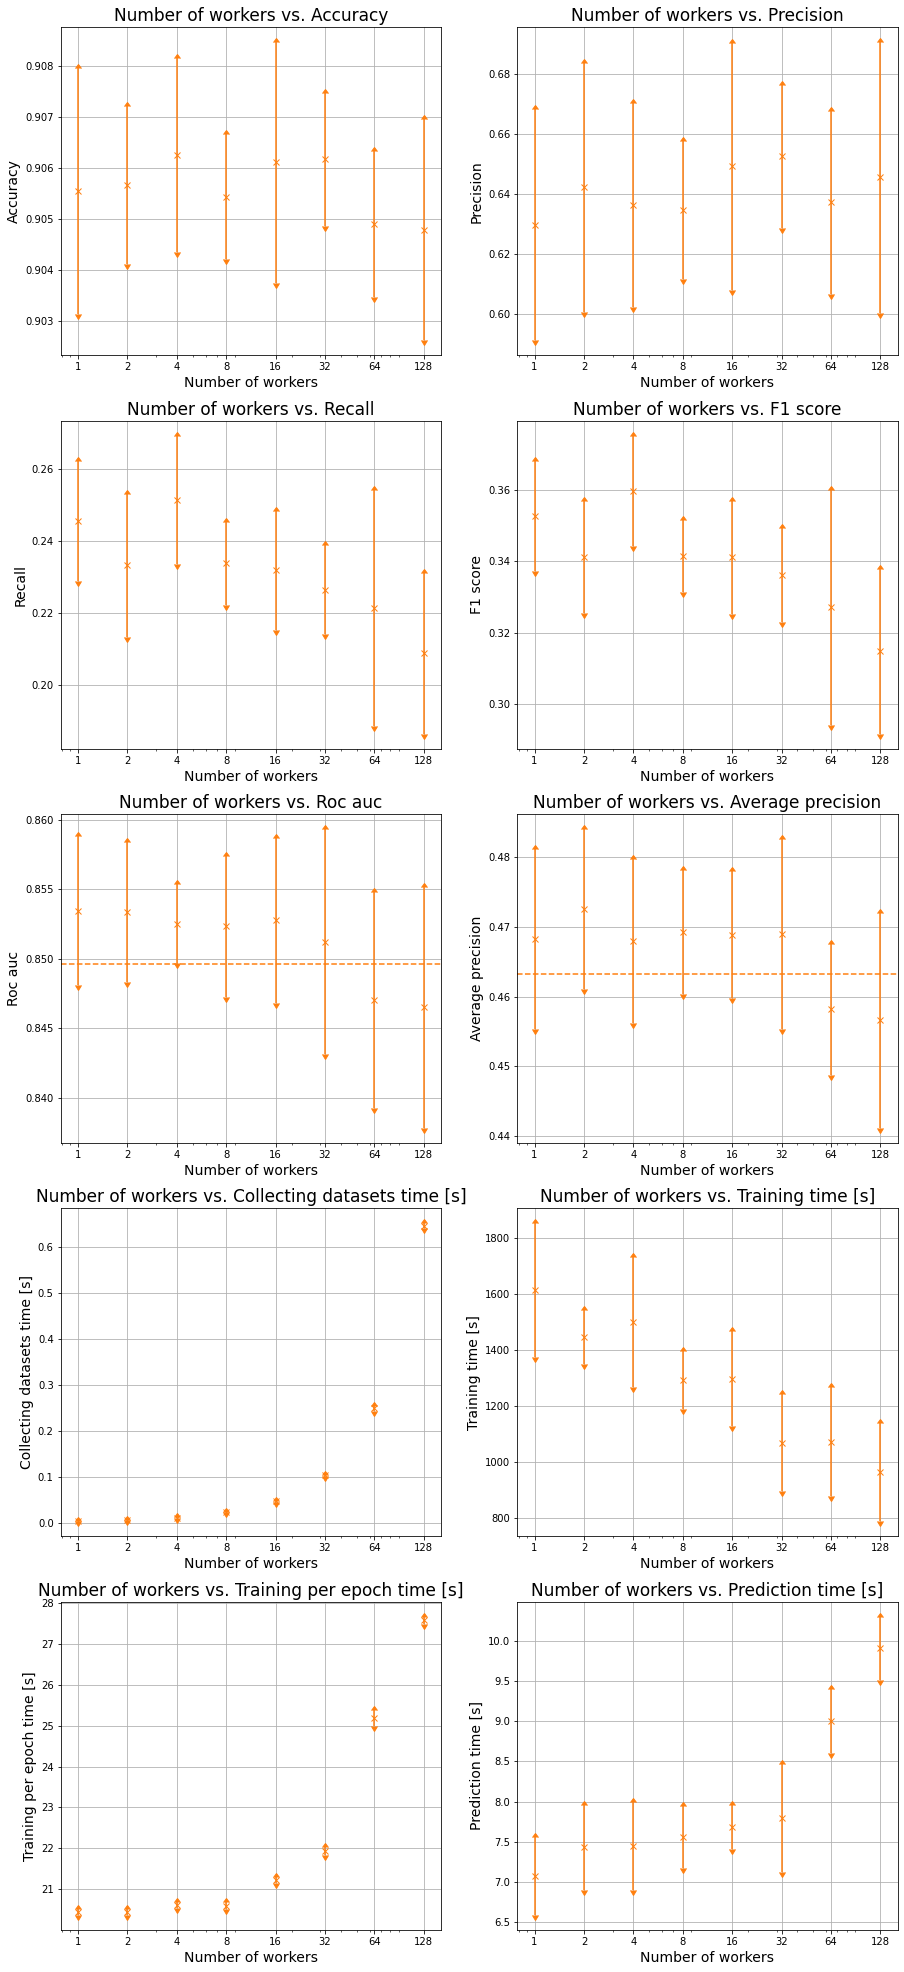

In [11]:
plot(grouped_mortality_workers, 'Number of workers', MORTALITY_TASKS)

In [12]:
grouped_mortality_node_distribution = aggregate_results(mortality_results, 'node distribution')
grouped_mortality_node_distribution

accuracy           precision              recall  \
                            mean       std      mean       std      mean   
node_distribution task                                                     
beta_center       1     0.905632  0.001660  0.642845  0.036041  0.229534   
beta_left_skewed  1     0.904790  0.001089  0.630619  0.026373  0.226583   
beta_right_skewed 1     0.905632  0.000970  0.640729  0.020406  0.229797   
linear            1     0.906165  0.000840  0.649208  0.021222  0.231137   
uniform           1     0.905688  0.001751  0.642184  0.033506  0.230869   

                                  f1_score             roc_auc            \
                             std      mean       std      mean       std   
node_distribution task                                                     
beta_center       1     0.015540  0.337584  0.013846  0.851222  0.005906   
beta_left_skewed  1     0.025058  0.332259  0.025451  0.850698  0.005470   
beta_right_skewed 1     0.011168  0.337975  0.010481  0.851014  0.005836   
linear            1     0.016118  0.340393  0.015225  0.851872  0.006333   
uniform           1     0.014357  0.339075  0.013449  0.850883  0.007698   

                       average_precision           collecting_datasets  \
                                    mean       std                mean   
node_distribution task                                                   
beta_center       1             0.465837  0.012845            0.106473   
beta_left_skewed  1             0.464919  0.009379            0.102618   
beta_right_skewed 1             0.471146  0.010906            0.104175   
linear            1             0.466137  0.013667            0.127985   
uniform           1             0.464537  0.010635            0.103086   

                                     training             training_per_epoch  \
                             std         mean         std               mean   
node_distribution task                                                         
beta_center       1     0.001373  1225.815706  159.342959          22.284510   
beta_left_skewed  1     0.000527  1080.378410  148.564542          21.959701   
beta_right_skewed 1     0.001865  1128.134413  131.330717          21.787694   
linear            1     0.055610  1091.568984  146.672318          21.920698   
uniform           1     0.002071   988.791414  121.490886          21.620511   

                                 prediction            
                             std       mean       std  
node_distribution task                                 
beta_center       1     0.081042   7.916302  0.455557  
beta_left_skewed  1     0.277010   7.905046  0.284097  
beta_right_skewed 1     0.332312   7.523880  0.361082  
linear            1     0.025885   7.555969  0.358752  
uniform           1     0.691895   7.336846  0.160476

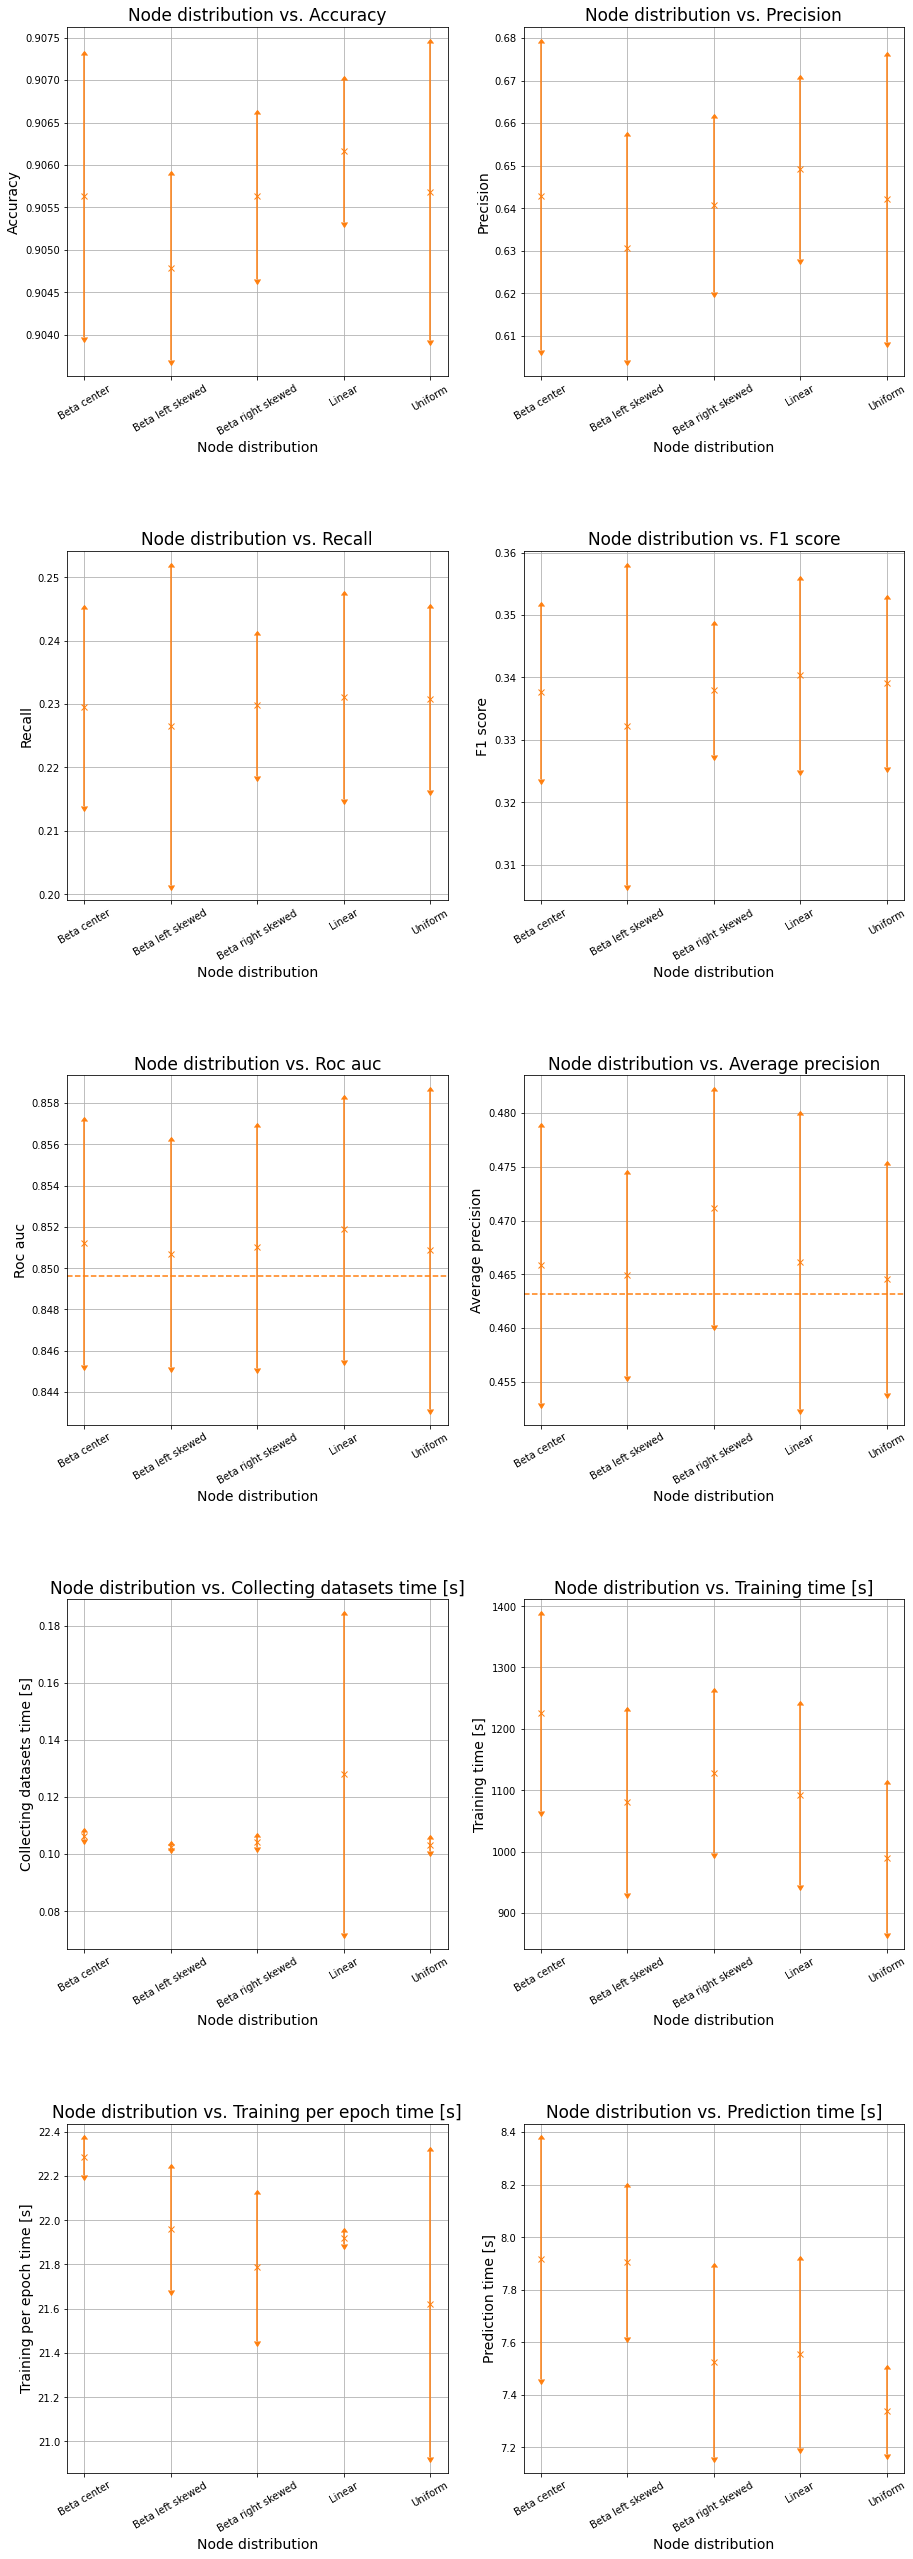

In [13]:
plot(grouped_mortality_node_distribution, 'Node distribution', MORTALITY_TASKS, is_x_categorical=True)

### Node size distributions visualization

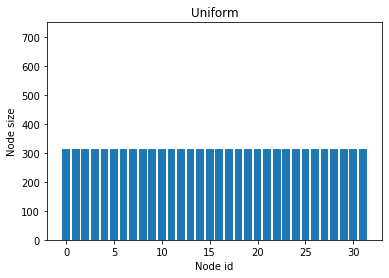

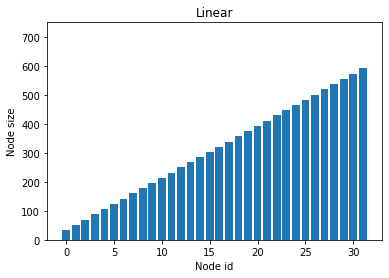

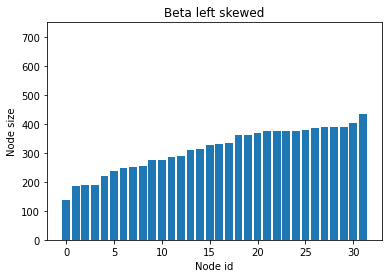

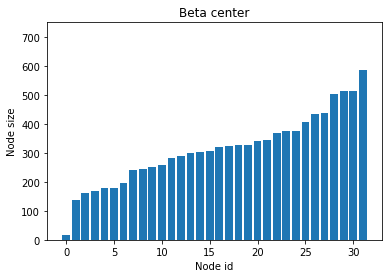

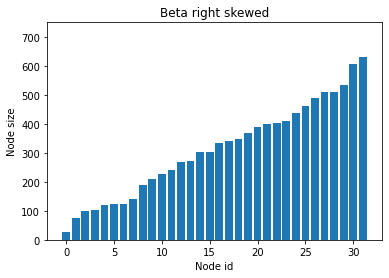

In [14]:
sample_data = torch.arange(10000)
distributions = [uniform, linear, beta_left_skewed, beta_center, beta_right_skewed]

for distribution in distributions:
    c = sorted([len(x) for x, _ in distribution(sample_data, sample_data, 32)])
    plt.bar(range(len(c)), c)
    plt.ylabel('Node size')
    plt.xlabel('Node id')
    plt.ylim(0, 750)
    plt.title(distribution.__name__.replace('_', ' ').capitalize())
    plt.show()

### ICD-9

In [15]:
icd9_results = pd.read_csv('results/icd9_multilabel_classification.csv')

In [16]:
grouped_icd9_train_size = aggregate_results(icd9_results, 'train size')
grouped_icd9_train_size

accuracy           precision              recall            \
                     mean       std      mean       std      mean       std   
train_size task                                                               
50.0       1     0.739113  0.005734  0.195478  0.268322  0.051436  0.083334   
           2     0.823064  0.002300  0.133333  0.298142  0.004358  0.009745   
           3     0.670679  0.023036  0.712225  0.035749  0.891324  0.148301   
           4     0.632183  0.003691  0.238433  0.331399  0.068548  0.139056   
           5     0.657464  0.050455  0.243167  0.227761  0.075206  0.146525   
...                   ...       ...       ...       ...       ...       ...   
10000.0    16    0.916274  0.003511  0.000000  0.000000  0.000000  0.000000   
           17    0.969501  0.001351  0.000000  0.000000  0.000000  0.000000   
           18    0.627722  0.004828  0.610633  0.009142  0.461715  0.019711   
           19    0.599355  0.009441  0.586597  0.008322  0.575098  0.073242   
           20    0.692452  0.004805  0.609994  0.024603  0.189357  0.030107   

                 f1_score             roc_auc           average_precision  \
                     mean       std      mean       std              mean   
train_size task                                                             
50.0       1     0.077454  0.119300  0.594953  0.047503          0.350070   
           2     0.008440  0.018873  0.652642  0.035010          0.326816   
           3     0.784255  0.041165  0.582123  0.109218          0.742544   
           4     0.088563  0.171162  0.603740  0.033297          0.478775   
           5     0.080701  0.141959  0.502144  0.036587          0.329062   
...                   ...       ...       ...       ...               ...   
10000.0    16    0.000000  0.000000  0.584007  0.017235          0.111128   
           17    0.000000  0.000000  0.670496  0.027676          0.057700   
           18    0.525537  0.010730  0.658691  0.002841          0.621891   
           19    0.578700  0.036457  0.642423  0.006389          0.598218   
           20    0.287500  0.032744  0.635833  0.004836          0.496487   

                          collecting_datasets              training  \
                      std                mean       std        mean   
train_size task                                                       
50.0       1     0.038477            0.009909  0.000094     7.68924   
           2     0.065322            0.009909  0.000094     7.68924   
           3     0.075553            0.009909  0.000094     7.68924   
           4     0.029507            0.009909  0.000094     7.68924   
           5     0.026923            0.009909  0.000094     7.68924   
...                   ...                 ...       ...         ...   
10000.0    16    0.004730            0.010015  0.000339  1028.91498   
           17    0.009386            0.010015  0.000339  1028.91498   
           18    0.002511            0.010015  0.000339  1028.91498   
           19    0.005447            0.010015  0.000339  1028.91498   
           20    0.010517            0.010015  0.000339  1028.91498   

                           training_per_epoch           prediction            
                       std               mean       std       mean       std  
train_size task                                                               
50.0       1      1.741724           0.215593  0.016520   8.696535  0.021058  
           2      1.741724           0.215593  0.016520   8.696535  0.021058  
           3      1.741724           0.215593  0.016520   8.696535  0.021058  
           4      1.741724           0.215593  0.016520   8.696535  0.021058  
           5      1.741724           0.215593  0.016520   8.696535  0.021058  
...                    ...                ...       ...        ...       ...  
10000.0    16    96.600078           8.977784  0.024504   8.837266  0.318362  
           17    96.600078           8.977784 

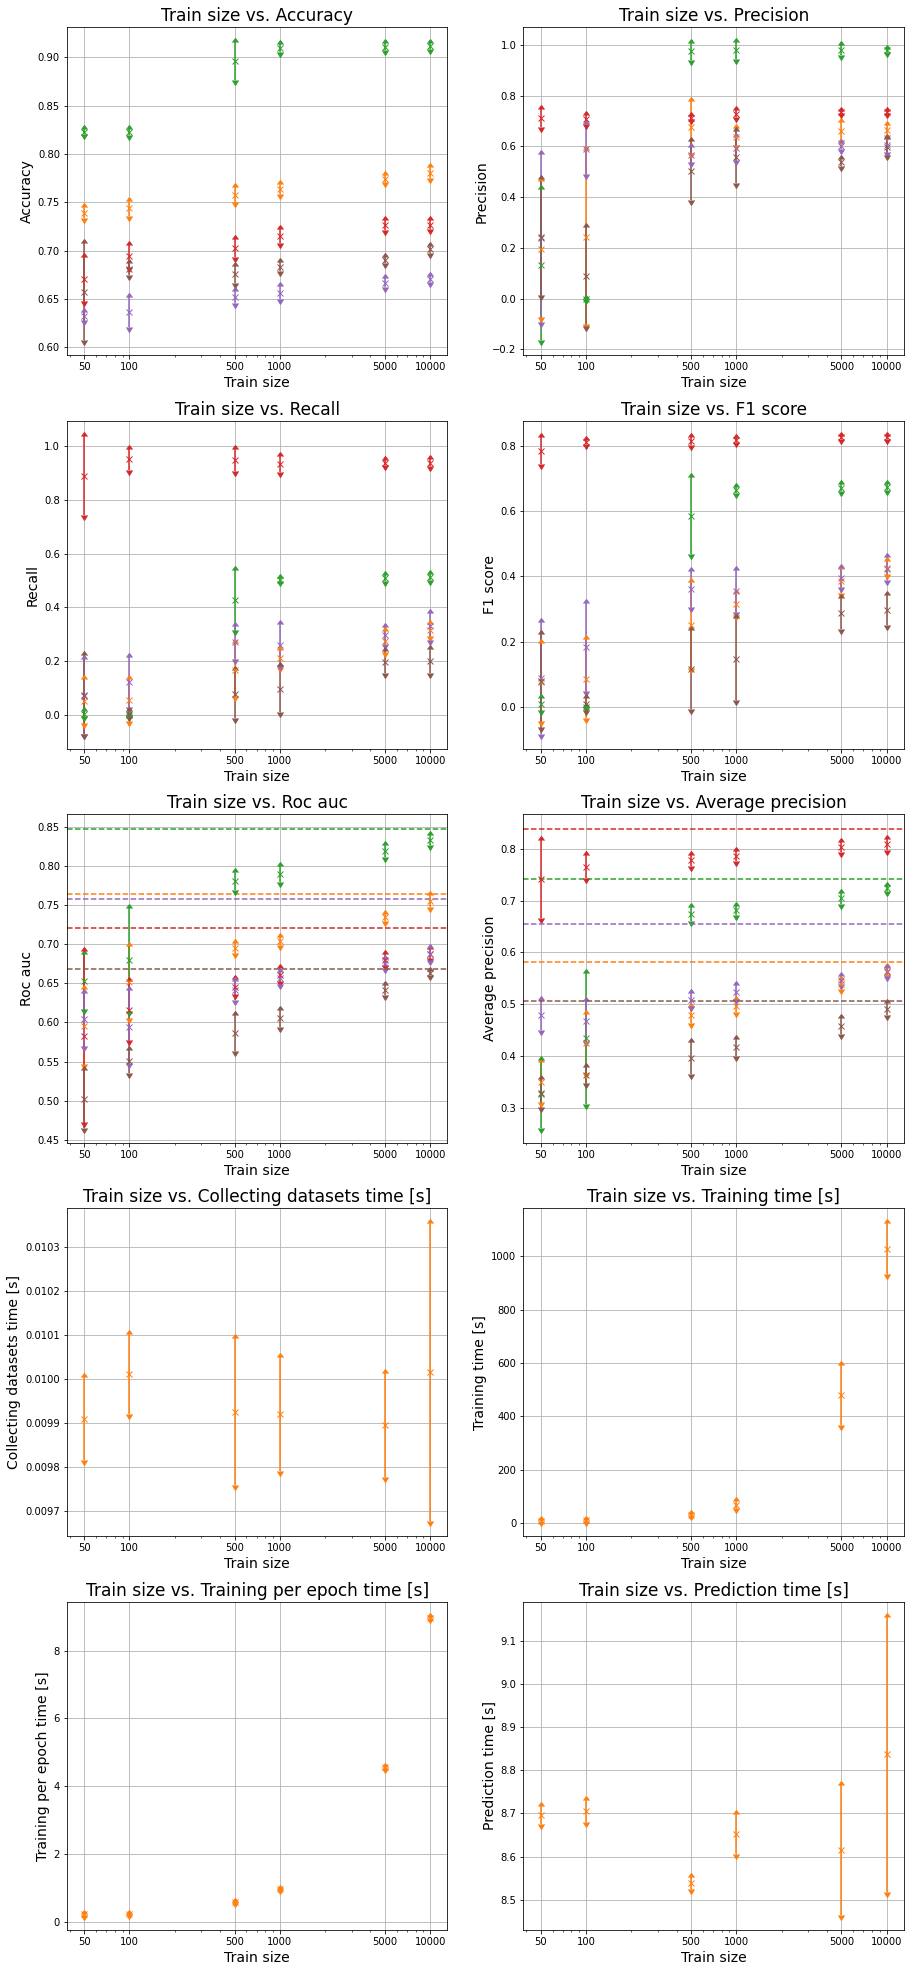

In [17]:
plot(grouped_icd9_train_size, 'Train size', ICD9_TASKS)

In [18]:
grouped_icd9_workers = aggregate_results(icd9_results, 'num of workers')
grouped_icd9_workers

accuracy           precision              recall  \
                         mean       std      mean       std      mean   
num_of_workers task                                                     
1              1     0.782716  0.003229  0.673821  0.020775  0.316575   
               2     0.912402  0.002994  0.980562  0.007307  0.516364   
               3     0.730219  0.005940  0.737129  0.006775  0.944028   
               4     0.675561  0.003550  0.606835  0.021233  0.357285   
               5     0.706734  0.005477  0.609300  0.016454  0.220983   
...                       ...       ...       ...       ...       ...   
128            16    0.916274  0.003511  0.000000  0.000000  0.000000   
               17    0.969501  0.001351  0.000000  0.000000  0.000000   
               18    0.634989  0.005582  0.637245  0.017600  0.428156   
               19    0.605892  0.006464  0.592096  0.007713  0.588593   
               20    0.700309  0.003835  0.676290  0.008302  0.173536   

                               f1_score             roc_auc            \
                          std      mean       std      mean       std   
num_of_workers task                                                     
1              1     0.014932  0.430343  0.010388  0.769826  0.006451   
               2     0.007863  0.676463  0.007516  0.849647  0.005091   
               3     0.008496  0.827812  0.004504  0.697838  0.005845   
               4     0.034842  0.448340  0.022034  0.701625  0.008450   
               5     0.018471  0.323974  0.020932  0.678409  0.003280   
...                       ...       ...       ...       ...       ...   
128            16    0.000000  0.000000  0.000000  0.572996  0.010720   
               17    0.000000  0.000000  0.000000  0.653543  0.010055   
               18    0.034556  0.511147  0.021071  0.670133  0.005063   
               19    0.034016  0.589850  0.015703  0.648798  0.007179   
               20    0.014058  0.275997  0.018248  0.649472  0.002550   

                    average_precision           collecting_datasets            \
                                 mean       std                mean       std   
num_of_workers task                                                             
1              1             0.582442  0.005869            0.004352  0.000120   
               2             0.745639  0.005851            0.004352  0.000120   
               3             0.817703  0.006294            0.004352  0.000120   
               4             0.579151  0.008435            0.004352  0.000120   
               5             0.512603  0.011868            0.004352  0.000120   
...                               ...       ...                 ...       ...   
128            16            0.105548  0.005876            0.882713  0.006113   
               17            0.054557  0.004227            0.882713  0.006113   
               18            0.634360  0.004588            0.882713  0.006113   
               19            0.602772  0.007299            0.882713  0.006113   
               20            0.513645  0.009039            0.882713  0.006113   

                        training             training_per_epoch            \
                            mean         std               mean       std   
num_of_workers task                                                         
1              1     2599.782615  112.062922          25.891197  0.220898   
               2     2599.782615  112.062922          25.891197  0.220898   
               3     2599.782615  112.062922          25.891197  0.220898   
               4     2599.782615  112.062922          25.891197  0.220898   
               5     2599.782615  112.062922          25.891197  0.220898   
...                          ...         ...                ...       ...   
128            16    1866.143338  310.056407          36.844556  0.362382   
               17    1866.143338  310.056407          36.844556  0.362

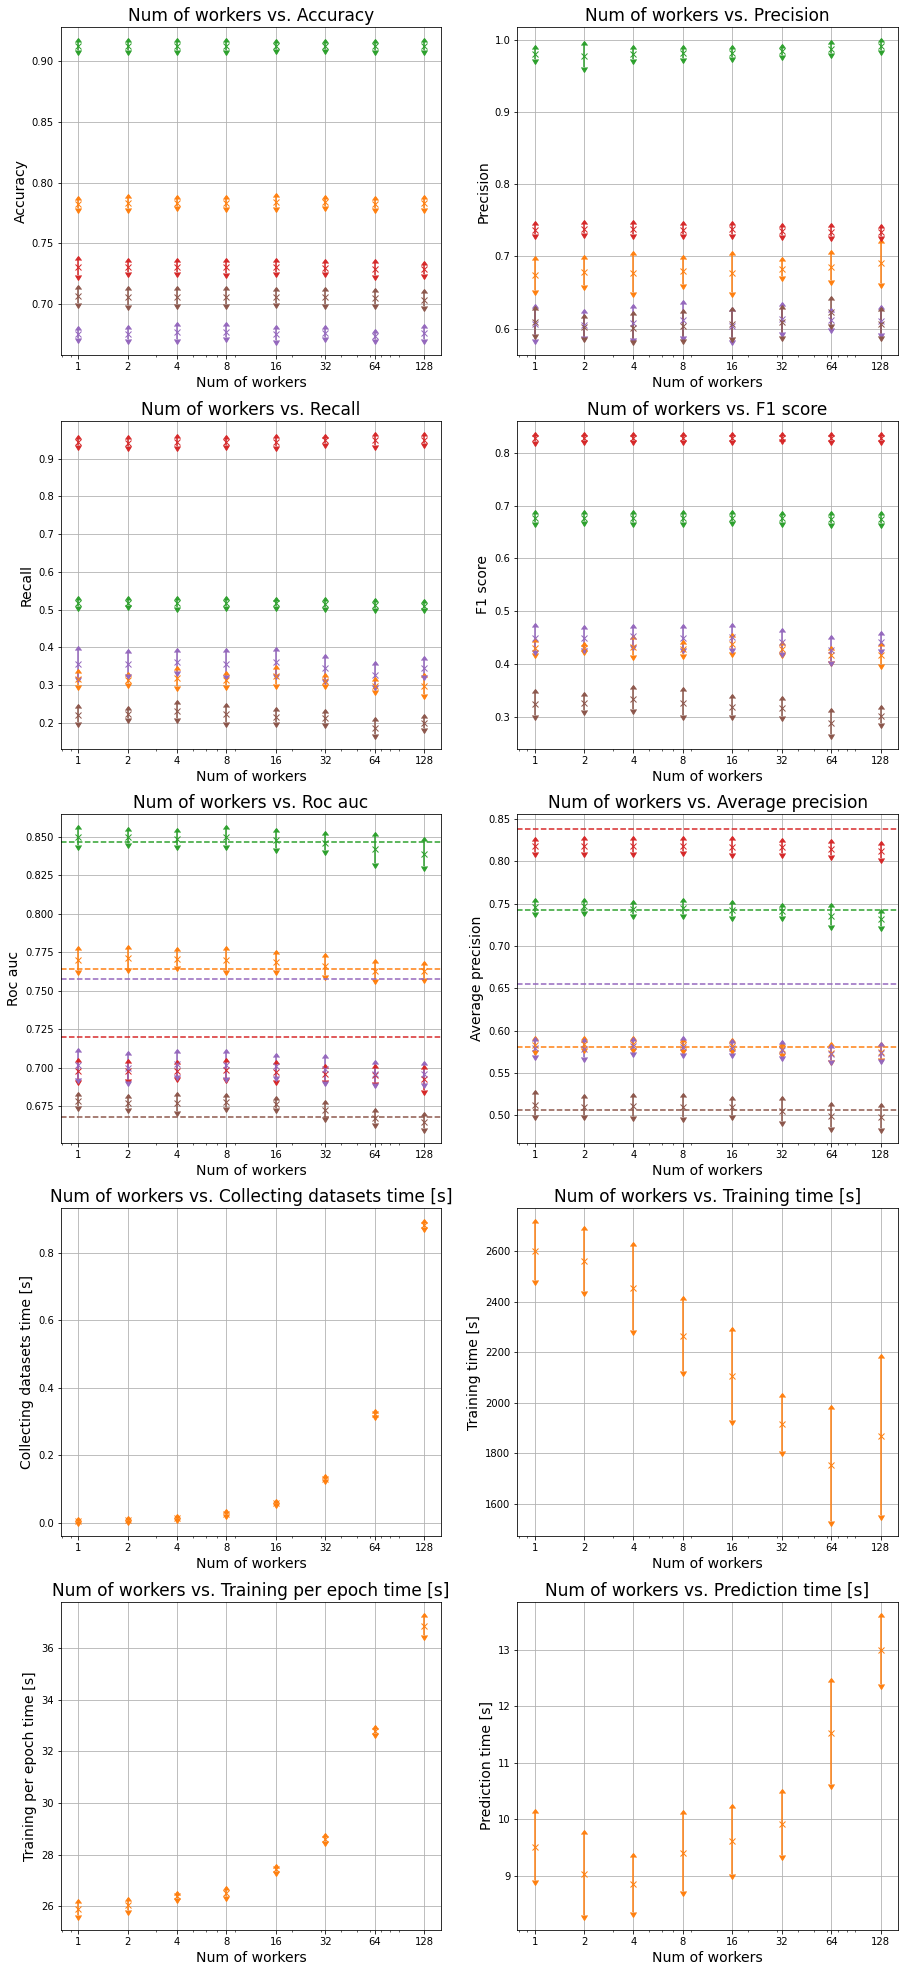

In [19]:
plot(grouped_icd9_workers, 'Num of workers', ICD9_TASKS)

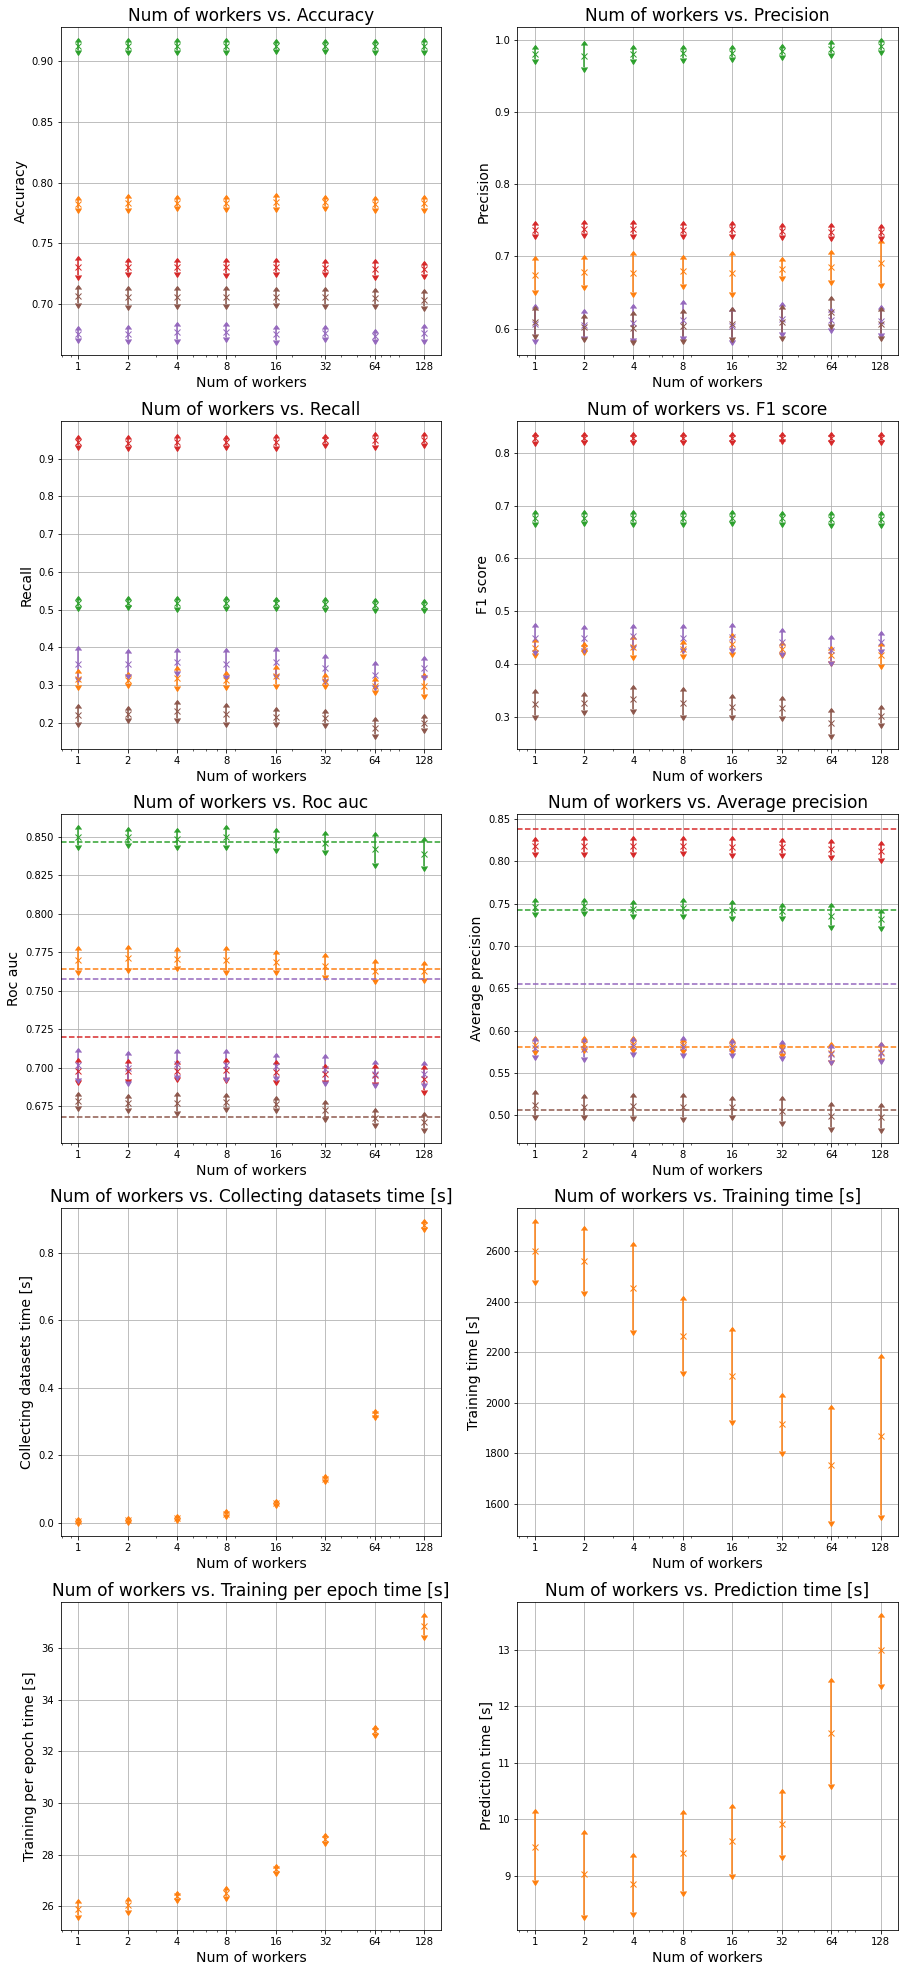

In [20]:
plot(grouped_icd9_workers, 'Num of workers', ICD9_TASKS)